In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.font_manager
import matplotlib as mpl
from glob import glob
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import h5py

path = Path.cwd()
root_path = list(path.parents)[1]
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=[path.parent / "figures" / 'fonts'], fontext='ttf')
matplotlib.font_manager.fontManager.addfont(font_files[0])

# specify matplotlib rc file
plt.style.use(root_path / ".matplotlibrc")
mpl.rcParams['font.family'] = 'Arial'

../../results/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
[[0.1036859  0.09385974 0.06262078]
 [0.09681911 0.08878412 0.05388863]
 [0.08461872 0.11338882 0.05543312]
 [0.20167905 0.09559633 0.04930538]
 [0.267681   0.11732858 0.04388031]
 [0.14257434 0.08696766 0.05077447]
 [0.07185977 0.07956398 0.06768074]
 [0.19031131 0.08062549 0.04443227]
 [0.0228008  0.1563421  0.05420134]
 [0.24144621 0.41688821 0.52759367]]
../../results/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=99-step=4000/specified_unknown_evaluate_samples.h5
../../results/diffusion/gaussian_mixture/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
[[ 4.02956676  0.8494131   0.68391865]
 [ 9.11606598  0.81193507  0.75564063]
 [26.54862022  0.69314563  0.66831225]
 [ 2.44931054  0.53664249  0.6113627 ]
 [ 9.71305847  0.72651112  0.76230127]
 [15.80575466  0.70951635  0.70694399]
 [79.16098785  0.87757

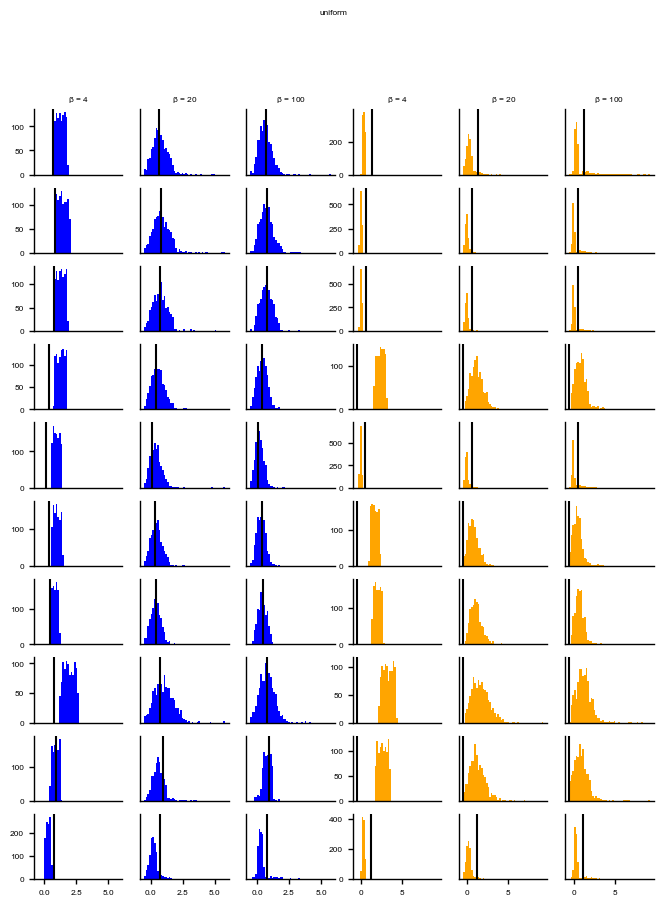

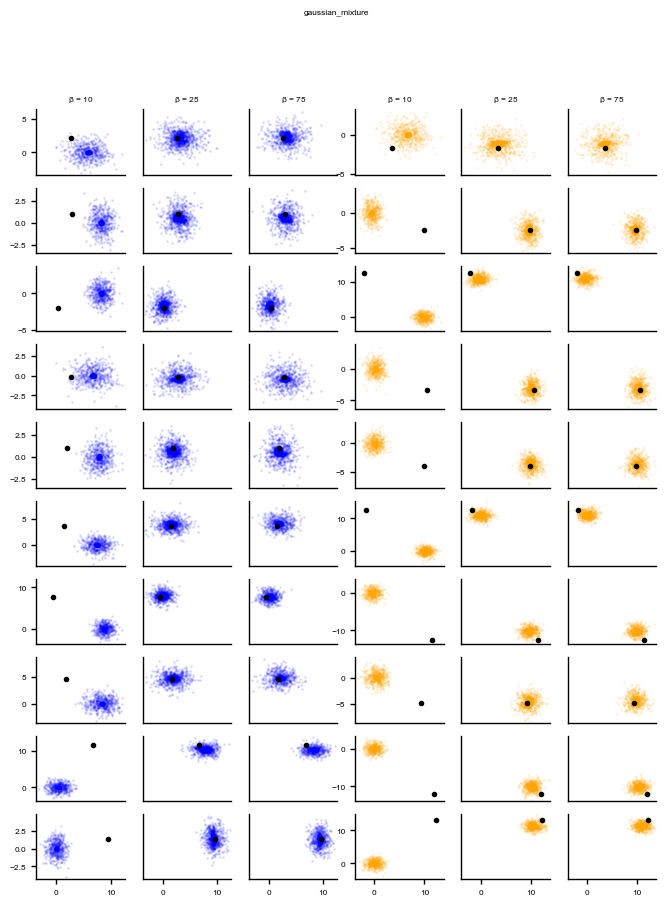

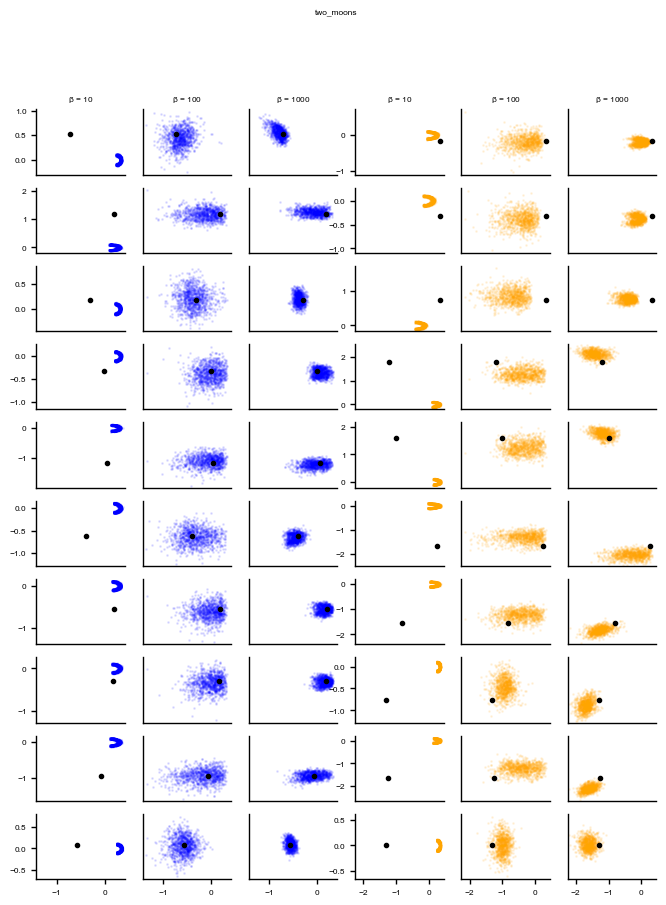

In [105]:
import json
from pathlib import Path
import h5py
import numpy as np
import pandas as pd

res_base_path = Path("../../results/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob(
    "*/lightning_logs/version_0/*/specified_unknown_evaluate_samples.h5"
):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    x_dim = attrs["x_o"].shape[1]
    if x_dim > 2:
        continue

    fig, axes = plt.subplots(
        ncols=len(attrs["betas"]) * 2,
        nrows=len(attrs["x_o"]),
        figsize=(8, 10),
        # sharex="row",
        # sharey="row",
    )
    x_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))
    y_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))  
    
    limit_base = np.concatenate([content["x_pred"], attrs["x_o"][None, None].repeat(len(attrs["betas"]), axis=0)], axis=1)
    lower = np.min(limit_base, axis=(0, 1))[..., 0]
    upper = np.max(limit_base, axis=(0, 1))[..., 0]
    
    res = np.zeros((len(attrs["x_o"]), len(attrs["betas"])))
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        if x_dim == 1:
            bins = np.linspace(lower[row], upper[row], 50)
            ax.hist(content["x_pred"][col, :, row, 0], bins=bins, color="b")
            ax.axvline(attrs["x_o"][row])
            # ax.set_yscale("log")
        elif x_dim == 2:
            ax.scatter(*content["x_pred"][col, :, row].T, color="b", s=1, alpha=0.1)
            ax.scatter(*attrs["x_o"][row])
        res[row, col] = np.mean(np.square(content["x_pred"][col, :, row] - attrs["x_o"][row]))

        x_lim[row, col] = np.array(ax.get_xlim())
        y_lim[row, col] = np.array(ax.get_ylim())
    print(res)
    x_lim = np.stack([np.min(x_lim[..., 0], axis=1), np.max(x_lim[..., 1], axis=1)]).T
    y_lim = np.stack([np.min(y_lim[..., 0], axis=1), np.max(y_lim[..., 1], axis=1)]).T
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        ax.set_xlim(x_lim[row])
        ax.set_ylim(y_lim[row])
        if row < 9:
            ax.set_xticks([], [])
        if col > 0:
            ax.set_yticks([], [])
        if row == 0:
            ax.set_title(fr"$\beta$ = {attrs["betas"][col]}")
            axes[row, col + 3].set_title(fr"$\beta$ = {attrs["betas"][col]}")

    

    # plot second half
    res_path = res_path.parent / Path("mis" + str(res_path.name))
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    x_dim = attrs["x_o"].shape[1]
    if x_dim > 2:
        continue

    x_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))
    y_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))  
    limit_base = np.concatenate([content["x_pred"], attrs["x_o"][None, None].repeat(len(attrs["betas"]), axis=0)], axis=1)
    lower = np.min(limit_base, axis=(0, 1))[..., 0]
    upper = np.max(limit_base, axis=(0, 1))[..., 0]
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col + 3]
        if x_dim == 1:
            bins = np.linspace(lower[row], upper[row], 50)
            ax.hist(content["x_pred"][col, :, row, 0], bins=bins, color="orange")
            ax.axvline(attrs["x_o"][row])
            # ax.set_yscale("log")
        elif x_dim == 2:
            ax.scatter(*content["x_pred"][col, :, row].T, color="orange", s=1, alpha=0.1)
            ax.scatter(*attrs["x_o"][row])
    
        x_lim[row, col] = np.array(ax.get_xlim())
        y_lim[row, col] = np.array(ax.get_ylim())

    x_lim = np.stack([np.min(x_lim[..., 0], axis=1), np.max(x_lim[..., 1], axis=1)]).T
    y_lim = np.stack([np.min(y_lim[..., 0], axis=1), np.max(y_lim[..., 1], axis=1)]).T
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col + 3]
        ax.set_xlim(x_lim[row])
        ax.set_ylim(y_lim[row])

        if row < 9:
            ax.set_xticks([], [])
        if col > 0:
            ax.set_yticks([], [])   
            
    task = list(res_path.parents)[3].name
    fig.suptitle(task)
    # fig.tight_layout()  

In [ ]:
res 

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

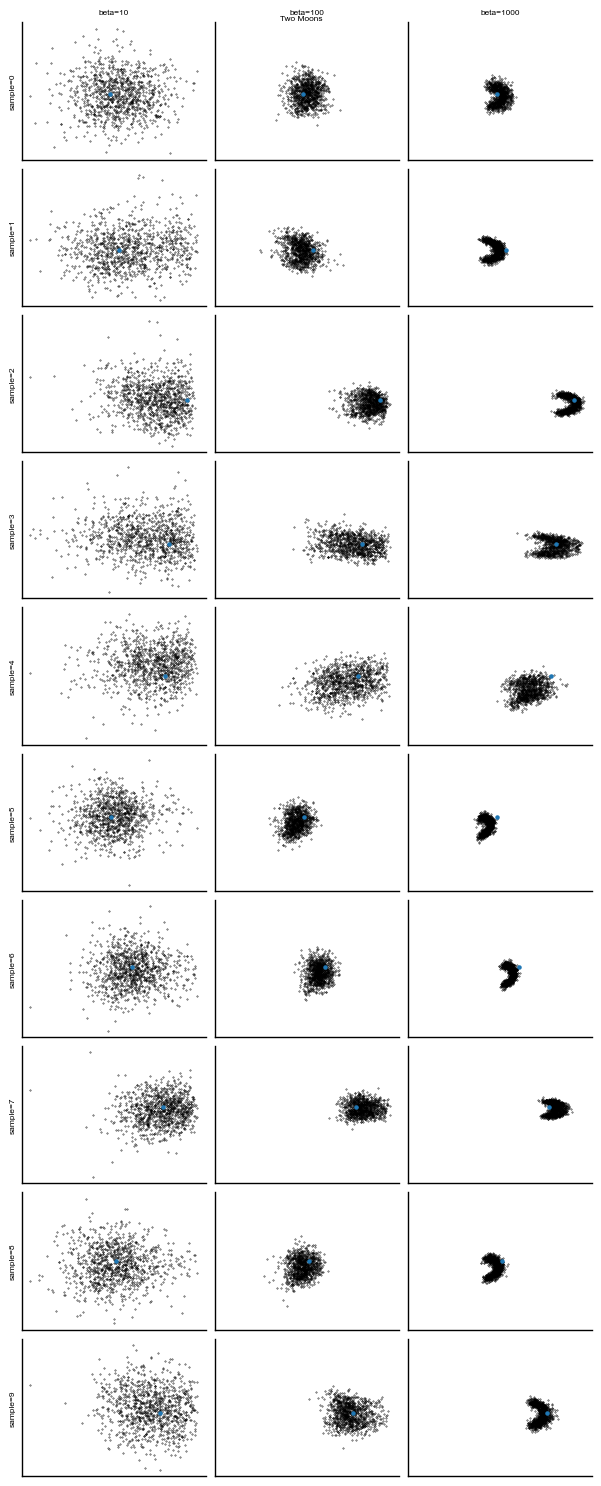

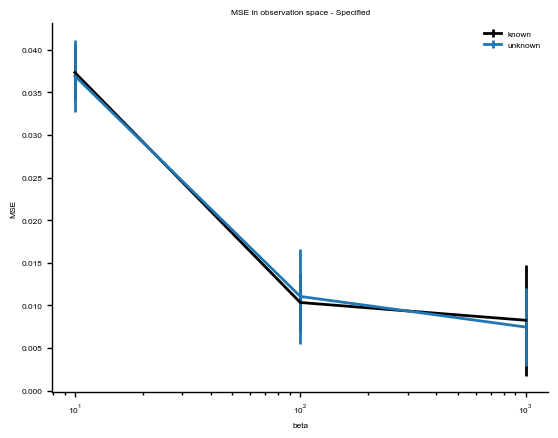

In [7]:
res_known = torch.load(
    "../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/specified_known_evaluate_samples.pt"
)
res_unknown = torch.load(
    "../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/specified_unknown_evaluate_samples.pt"
)

fig, axs = plt.subplots(ncols=3, nrows=10, figsize=(6, 15), sharex="row", sharey="row")

for row, col in np.ndindex(10, 3):
    ax = axs[row, col]
    ax.scatter(*res_known["x_pred"][col, :, row].T.detach().numpy(), s=0.1)
    ax.scatter(*res_known["x_o"][row], s=5)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if row == 0:
        beta = res_known["betas"][col]
        ax.set_title(f"{beta=}")

    if col == 0:
        ax.set_ylabel(f"sample={row}")

fig.suptitle("Two Moons")
fig.tight_layout()

fig, ax = plt.subplots()

diff = torch.mean((res_known["x_pred"] - res_known["x_o"]) ** 2, dim=-1).detach()
mean = diff.mean(dim=1)
# for row in range(10):
#     ax.plot(res_known["betas"], mean, color="k", alpha=0.01)
ax.errorbar(res_known["betas"], mean.mean(dim=1), mean.std(dim=1), linewidth=2, label="known")

diff = torch.mean((res_unknown["x_pred"] - res_unknown["x_o"]) ** 2, dim=-1).detach()
mean = diff.mean(dim=1)
# for row in range(10):
#     ax.plot(res_known["betas"], mean, color="k", alpha=0.01)
ax.errorbar(res_unknown["betas"], mean.mean(dim=1), mean.std(dim=1), linewidth=2, label="unknown")

ax.set_xscale("log")
ax.set_title("MSE in observation space - Specified")
ax.set_xlabel("beta")
ax.set_ylabel("MSE")
ax.legend()

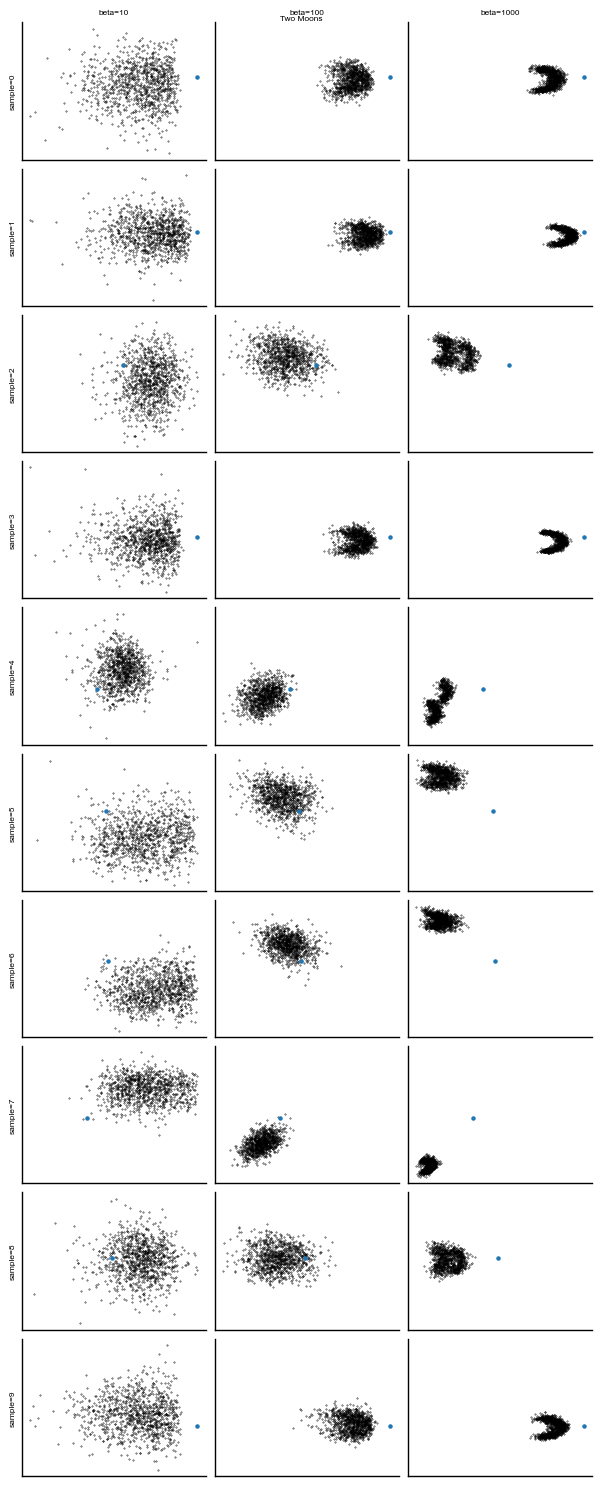

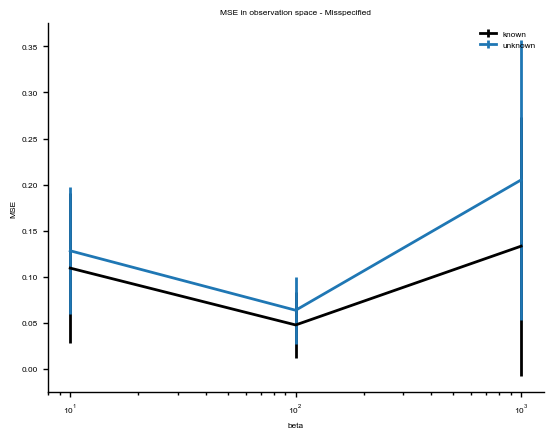

In [8]:
res_known = torch.load("../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/misspecified_known_evaluate_samples.pt")
res_unknown = torch.load("../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/misspecified_unknown_evaluate_samples.pt")

fig, axs = plt.subplots(ncols=3, nrows=10, figsize=(6, 15), sharex="row", sharey="row")

for row, col in np.ndindex(10, 3):
    ax = axs[row, col]
    ax.scatter(*res_known["x_pred"][col, :, row].T.detach().numpy(), s=0.1)
    ax.scatter(*res_known["x_o"][row], s=5)
    ax.set_xticks([],[])
    ax.set_yticks([],[])
    if row == 0:
        beta = res_known["betas"][col]
        ax.set_title(f"{beta=}")

    if col == 0:
        ax.set_ylabel(f"sample={row}")

fig.suptitle("Two Moons")
fig.tight_layout()

fig, ax = plt.subplots()

diff = torch.mean((res_known["x_pred"] - res_known["x_o"]) ** 2, dim=-1).detach()
mean = diff.mean(dim=1)
# for row in range(10):
#     ax.plot(res_known["betas"], mean, color="k", alpha=0.01)
ax.errorbar(res_known["betas"], mean.mean(dim=1), mean.std(dim=1), linewidth=2, label="known")

diff = torch.mean((res_unknown["x_pred"] - res_unknown["x_o"]) ** 2, dim=-1).detach()
mean = diff.mean(dim=1)
# for row in range(10):
#     ax.plot(res_known["betas"], mean, color="k", alpha=0.01)
ax.errorbar(res_unknown["betas"], mean.mean(dim=1), mean.std(dim=1), linewidth=2, label="unknown")

ax.set_xscale("log")
ax.set_title("MSE in observation space - Misspecified")
ax.set_xlabel("beta")
ax.set_ylabel("MSE")
ax.legend()

In [84]:
import json
from pathlib import Path
import h5py
import numpy as np
import pandas as pd 

res_base_path = Path("../../results/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob("*/lightning_logs/version_0/*/*_unknown_evaluate_samples.h5"):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    # for key, value in content.attrs.items():
    #     print(key, value)
    # content = torch.load(res_path)
    
    x_o = attrs["x_o"] if "x_o" in attrs.keys() else content["x_o"]
    
    # print(content["x_pred"].shape)
    # print(content["theta"][0] == content["theta"][1])
    # print(content["x_pred"][0] == content["x_pred"][1])
    mse = np.mean(np.square((content["x_pred"] - x_o[None, None,])), axis=(1, 3))# .detach()
    specified, known, _, _ = res_path.stem.split("_")
    task = list(res_path.parents)[3].name
    # task = res_path.parents[]
    data = {
        "task": task,
        "specified": specified,
        "known": known,
        "betas": content.attrs["betas"],
        "mse": mse.tolist(),
        # "mse_mean": np.median(mse,-1),
        # "mse_std": mse.std(-1),
    }
    dfs.append(pd.DataFrame(data))
    content.close()
df = pd.concat(dfs)
df = df.set_index(["task", "specified", "known", "betas"])
df.sort_index()


../../results/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/misspecified_unknown_evaluate_samples.h5
../../results/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
../../results/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=99-step=4000/misspecified_unknown_evaluate_samples.h5
../../results/diffusion/linear_gaussian/lightning_logs/version_0/samples_epoch=99-step=4000/specified_unknown_evaluate_samples.h5
../../results/diffusion/gaussian_mixture/lightning_logs/version_0/samples_epoch=89-step=3600/misspecified_unknown_evaluate_samples.h5
../../results/diffusion/gaussian_mixture/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/misspecified_unknown_evaluate_samples.h5
../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/specified_un

mse
task             specified    known   betas                                                   
gaussian_mixture misspecified unknown 10     [2.907113790512085, 51.5093879699707, 151.0307...
                                      25     [0.7381895184516907, 0.669698178768158, 3.3197...
                                      75     [0.6748082637786865, 0.6055099964141846, 3.174...
                 specified    unknown 10     [4.029568195343018, 9.116064071655273, 26.5486...
                                      25     [0.8494131565093994, 0.8119350671768188, 0.693...
                                      75     [0.6839190721511841, 0.7556403279304504, 0.668...
linear_gaussian  misspecified unknown 1      [11.84200668334961, 11.024544715881348, 14.928...
                                      10     [12.979187965393066, 11.876322746276855, 15.68...
                                      100    [12.532159805297852, 11.841053009033203, 15.28...
                 specified    unknown 1      [2.9155666828155518, 2.278885841369629, 1.8211...
                                      10     [3.883824586868286, 3.1506567001342773, 2.6965...
                                      100    [3.356266736984253, 2.3946354389190674, 2.1508...
two_moons        misspecified unknown 10     [0.018189769238233566, 0.06309609860181808, 0....
                                      100    [0.04971809685230255, 0.05571136996150017, 0.1...
                                      1000   [0.012600948102772236, 0.017529286444187164, 0...
                 specified    unknown 10     [0.6635597944259644, 0.6901608109474182, 0.173...
                                      100    [0.040003418922424316, 0.040550220757722855, 0...
                                      1000   [0.01574321649968624, 0.023044787347316742, 0....
uniform          misspecified unknown 4      [0.8438789248466492, 0.8693050146102905, 0.829...
                                      20     [1.1359087228775024, 1.1719695329666138, 1.189...
                                      100    [1.4910277128219604, 1.694908857345581, 1.6987...
                 specified    unknown 4      [0.1036858931183815, 0.09681914001703262, 0.08...
                                      20     [0.09385974705219269, 0.08878415077924728, 0.1...
                                      100    [0.06262074410915375, 0.053888626396656036, 0....

In [68]:
tasks = df["task"].unique().tolist()
print(tasks)
specifieds = df["specified"].unique().tolist()

fig, axs = plt.subplots(nrows=len(tasks), ncols=len(specifieds), figsize=(4, 2))

for idx, data in df.groupby(["task", "specified", "known"]):
    task, specified, known = idx

    if known == "unknown":
        continue
    betas = data["betas"]

    row_idx = tasks.index(task)
    col_idx = specifieds.index(specified)
    ax = axs[col_idx]
    ax.errorbar(
        data["betas"].astype(str), data["mse_mean"], data["mse_std"], label="GBI-Diff "
    )
    ax.set_title(specified)

axs[0].set_ylabel("MSE")

fig.suptitle(f"MSE - {task}")


gbi_benchmark_misspecified = {
    "betas": ["10", "100", "1000"],
    "mean": [0.113898, 0.111917, 0.112072],
    "std": [0.227978, 0.127735, 0.115481],
}

gbi_benchmark_specified = {
    "betas": ["10", "100", "1000"],
    "mean": [0.081393, 0.017173, 0.006345],
    "std": [0.013825, 0.003511, 0.001873],
}

axs[0].errorbar(gbi_benchmark_misspecified["betas"], gbi_benchmark_misspecified["mean"], gbi_benchmark_misspecified["std"], label="ACE-GBI")
axs[1].errorbar(gbi_benchmark_specified["betas"], gbi_benchmark_specified["mean"], gbi_benchmark_specified["std"], label="ACE-GBI")
axs[1].legend()                                            

KeyError: 'task'

uniform specified
           mean       std
beta                     
4.0    0.094360  0.077540
20.0   0.049991  0.027078
100.0  0.027609  0.002308


/tmp/ipykernel_10895/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


uniform misspecified
           mean       std
beta                     
4.0    0.531265  0.286665
20.0   0.151899  0.036086
100.0  0.108193  0.025069


/tmp/ipykernel_10895/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


two_moons specified
            mean       std
beta                      
10.0    0.081393  0.013825
100.0   0.017173  0.003511
1000.0  0.006345  0.001873


/tmp/ipykernel_10895/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


two_moons misspecified
            mean       std
beta                      
10.0    0.227978  0.113898
100.0   0.127735  0.111917
1000.0  0.115481  0.112072


/tmp/ipykernel_10895/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


linear_gaussian specified
           mean       std
beta                     
1.0    3.731448  0.852989
10.0   1.653358  0.233905
100.0  0.990434  0.101110


/tmp/ipykernel_10895/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


linear_gaussian misspecified
            mean       std
beta                      
1.0    11.687236  2.797506
10.0    3.755213  0.802263
100.0   1.768628  0.461014


/tmp/ipykernel_10895/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


gaussian_mixture specified
          mean       std
beta                    
10.0  0.104372  0.009963
25.0  0.046866  0.004195
75.0  0.024143  0.002446


/tmp/ipykernel_10895/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


gaussian_mixture misspecified
          mean       std
beta                    
10.0  0.259122  0.063547
25.0  0.208299  0.075941
75.0  0.184428  0.083844


/tmp/ipykernel_10895/1356577817.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_df = df.loc[tmp_dataset, specified, "unknown"]


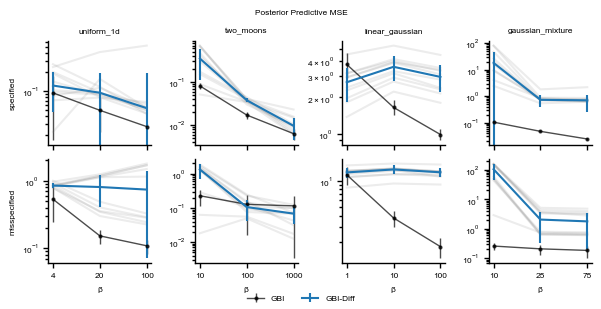

In [99]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(6, 3), sharex="col")
datasets = ["uniform_1d", "two_moons", "linear_gaussian", "gaussian_mixture"]
is_specified = ["specified", "misspecified"]


for col_idx, dataset in enumerate(datasets):
    df_summaries = pd.read_csv(f"GBI_results_{datasets[col_idx]}.csv")
    for row_idx, specified in enumerate(is_specified):
        ax = axs[row_idx, col_idx]

        if row_idx == 0:
            ax.set_title(dataset)
        elif row_idx == 1:
            ax.set_xlabel(r"$\beta$")

        if col_idx == 0:
            ax.set_ylabel(specified)

        df_collapsed = df_summaries.groupby(
            ["algorithm", "beta", "xo_specified", "xo_known"]
        ).describe()
        df_cur = df_collapsed.loc["GBI", :, specified, "unknown"]["dist_samples_mean"]
        gbi_line = ax.errorbar(
            df_cur.index.astype(int).astype(str),
            df_cur["mean"].values,
            yerr=df_cur["std"].values,
            fmt="-o",
            label="GBI",
            lw=1,
            alpha=0.7,
            markersize=2,
        )

        tmp_dataset = dataset
        if dataset == "uniform_1d":
            tmp_dataset = "uniform"
        print(tmp_dataset, specified)
        print(df_cur[["mean", "std"]])
        tmp_df = df.loc[tmp_dataset, specified, "unknown"]
        # tmp_df = df[(df["task"] == tmp_dataset) & (df["specified"] == specified)]
        mse = np.array(tmp_df["mse"].to_list())
        ax.plot(tmp_df.index.astype(str), mse, color="grey", alpha=0.15)
        gbi_diff_line = ax.errorbar(
            tmp_df.index.astype(str),
            np.median(mse, axis=1),
            np.std(mse, axis=1),
            label="GBI-Diff",
        )
        ax.set_yscale("log")

fig.suptitle("Posterior Predictive MSE")
fig.legend((gbi_line, gbi_diff_line), ("GBI", "GBI-Diff"), loc="lower center", ncol=2)
fig.tight_layout()

In [ ]:
                import numpy as np      
            
a = np.arange(48).reshape(2, 4, 6)
s = slice(1, 2)
a[s, 0] = np.zeros_like(a[s, 0])
a

array([[[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23]],

       [[ 0,  0,  0,  0,  0,  0],
        [30, 31, 32, 33, 34, 35],
        [36, 37, 38, 39, 40, 41],
        [42, 43, 44, 45, 46, 47]]])

In [84]:
import json
from pathlib import Path
import h5py
import numpy as np
import pandas as pd 

res_base_path = Path("../../results/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob("uniform/lightning_logs/version_0/*/specified_unknown_evaluate_samples.h5"):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    # for key, value in content.attrs.items():
    #     print(key, value)
    # content = torch.load(res_path)
    
    x_o = attrs["x_o"] if "x_o" in attrs.keys() else content["x_o"]
    
    # print(content["x_pred"].shape)
    # print(content["theta"][0] == content["theta"][1])
    # print(content["x_pred"][0] == content["x_pred"][1])
    mse = np.mean((content["x_pred"] - x_o) ** 2, axis=-1)# .detach()
    mse = mse.mean((1))
    specified, known, _, _ = res_path.stem.split("_")
    print(specified, known)
    task = list(res_path.parents)[3].name
    # task = res_path.parents[]
    data = {
        "task": task,
        "specified": specified,
        "known": known,
        "betas": content.attrs["betas"],
        "mse_mean": mse.mean(-1),
        "mse_std": mse.std(-1),
    }
    dfs.append(pd.DataFrame(data))
    content.close()
df = pd.concat(dfs)
df

../../results/diffusion/uniform/lightning_logs/version_0/samples_epoch=89-step=3600/specified_unknown_evaluate_samples.h5
specified unknown


,task,specified,known,betas,mse_mean,mse_std
0,uniform,specified,unknown,4,0.142348,0.075835
1,uniform,specified,unknown,20,0.132964,0.097167
2,uniform,specified,unknown,100,0.101417,0.143528


<Axes: xlabel='betas'>

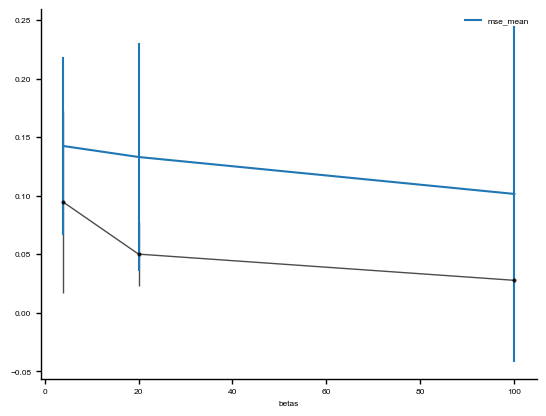

In [85]:
fig, ax = plt.subplots()

df_summaries = pd.read_csv(f"GBI_results_uniform_1d.csv")
df_collapsed = df_summaries.groupby(['algorithm','beta','xo_specified', 'xo_known']).describe()
df_cur = df_collapsed.loc["GBI", :, "specified", "unknown"]["dist_samples_mean"]
gbi_line = ax.errorbar(df_cur.index, df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o',label="GBI", lw=1, alpha=0.7, markersize=2)
        
df.plot("betas", "mse_mean", yerr="mse_std", ax=ax)# .set(yscale="log")

In [ ]:
import torch
{**torch.load("../../data/gaussian_mixture_100.pt"), "": True}

{'_theta': tensor([[ 7.6454,  8.3001],
         [-2.3427,  9.1861],
         [-2.1910,  2.0179],
         [-4.8686,  5.8728],
         [ 8.8154, -7.3363],
         [ 8.6920,  1.8716],
         [ 7.3881,  1.3543],
         [ 4.8219, -1.4119],
         [ 7.7089,  1.4781],
         [-4.6684,  2.5490],
         [-4.6074, -1.1727],
         [-4.0616,  6.6337],
         [-7.8937, -4.6101],
         [-2.8237, -6.0127],
         [ 0.9438, -9.8768],
         [ 9.0311, -8.4947],
         [ 7.7203,  1.6642],
         [-3.2470,  6.1795],
         [ 1.5585,  8.0796],
         [ 1.0932, -3.1537],
         [ 2.6868, -2.7118],
         [ 4.2086,  8.9282],
         [ 5.7806, -4.3717],
         [ 5.7726,  1.7893],
         [ 5.0784, -6.0951],
         [-9.8991, -3.8636],
         [-7.6702,  8.2054],
         [ 2.8803,  4.1421],
         [ 3.1626, -0.1740],
         [ 7.8261, -7.1051],
         [ 0.6296, -6.8254],
         [ 3.0835, -3.4438],
         [ 3.0642, -2.0834],
         [ 8.2939, -5.9270],
    

../../results_normalized/diffusion/two_moons/lightning_logs/version_0/samples_epoch=94-step=3800/test.h5


Text(0.5, 1.0, 'two moons misspecified')

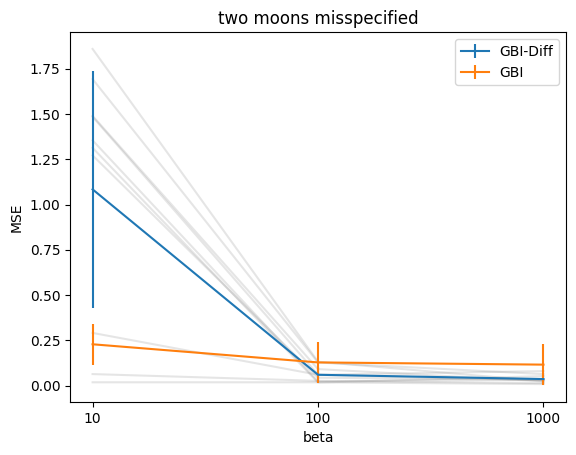

In [29]:
import json
from pathlib import Path
import h5py
import numpy as np
import pandas as pd 

res_base_path = Path("../../results_normalized/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob("*/lightning_logs/version_0/*/test.h5"):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    # for key, value in content.attrs.items():
    #     print(key, value)
    # content = torch.load(res_path)
    
    x_o = attrs["x_o"] if "x_o" in attrs.keys() else content["x_o"]
    
    # print(content["x_pred"].shape)
    # print(content["theta"][0] == content["theta"][1])
    # print(content["x_pred"][0] == content["x_pred"][1])
    mse = np.mean(np.square((content["x_pred"] - x_o[None, None,])), axis=(1, 3))# .detach()
    # specified, known, _, _ = res_path.stem.split("_")
    task = list(res_path.parents)[3].name
    # task = res_path.parents[]
    data = {
        "task": task,
        # "specified": specified,
        # "known": known,
        "betas": content.attrs["betas"],
        "mse": mse.tolist(),
        # "mse_mean": np.median(mse,-1),
        # "mse_std": mse.std(-1),
    }
    dfs.append(pd.DataFrame(data))
    content.close()
df = pd.concat(dfs)
# df = df.set_index(["task", "specified", "known", "betas"])
df.sort_index()     

import matplotlib.pyplot as plt
plt.plot(df["betas"].astype(str), np.array(df["mse"].tolist()), color="grey", alpha=0.2)
plt.errorbar(df["betas"].astype(str), np.array(df["mse"].tolist()).mean(1), np.array(df["mse"].tolist()).std(1), label="GBI-Diff")
plt.errorbar(["10", "100", "1000"], np.array([0.227978, 0.127735, 0.115481]), np.array([0.113898, 0.111917, 0.112072]), label="GBI")
np.array(df["mse"].tolist()).mean(axis=1),np.array(df["mse"].tolist()).std(axis=1) 
plt.legend()
plt.xlabel("beta")
plt.ylabel("MSE")
plt.title("two moons misspecified")

In [ ]:
two_moons misspecified
            mean       std
beta                      
10.0    0.227978            
100.0   0.127735            
1000.0  0.115481            

SyntaxError: invalid syntax (3323219467.py, line 1)

../../results_normalized/diffusion/two_moons/lightning_logs/version_0/samples_epoch=94-step=3800/test.h5
[[0.01794623 0.01796893 0.00783035]
 [0.06331262 0.02587802 0.01348477]
 [0.29076496 0.05936587 0.02973427]
 [1.85974193 0.1315795  0.02361046]
 [1.48973906 0.09072579 0.02318144]
 [1.35494852 0.0221901  0.03363508]
 [1.27178395 0.04319955 0.0318305 ]
 [1.48508692 0.0597285  0.0797254 ]
 [1.6932652  0.12718636 0.06305441]
 [1.31324923 0.01664122 0.05220591]]


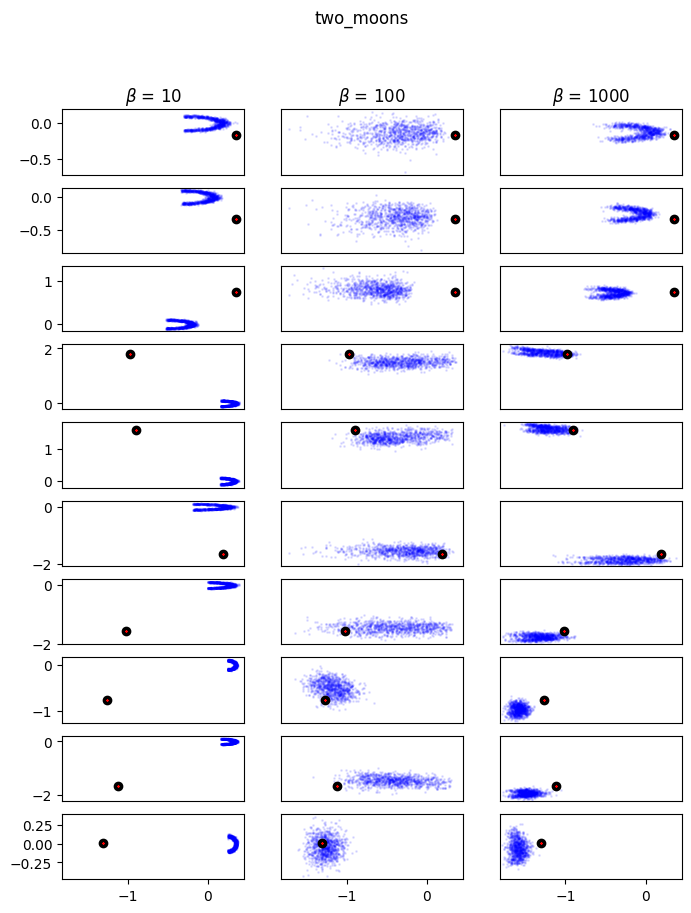

In [24]:
import json
from pathlib import Path
import h5py
import numpy as np
import pandas as pd

res_base_path = Path("../../results_normalized/diffusion")
# task = "two_moons"
log_dir = res_base_path

dfs = []
for res_path in log_dir.glob(
    "*/lightning_logs/version_0/*/test.h5"
):
    print(res_path)
    content = h5py.File(res_path, "r")
    attrs = {k: v for k, v in content.attrs.items()}
    x_dim = attrs["x_o"].shape[1]
    if x_dim > 2:
        continue

    fig, axes = plt.subplots(
        ncols=len(attrs["betas"]),
        nrows=len(attrs["x_o"]),
        figsize=(8, 10),
        # sharex="row",
        # sharey="row",
    )
    x_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))
    y_lim = np.zeros((len(attrs["x_o"]), len(attrs["betas"]), 2))  
    
    limit_base = np.concatenate([content["x_pred"], attrs["x_o"][None, None].repeat(len(attrs["betas"]), axis=0)], axis=1)
    lower = np.min(limit_base, axis=(0, 1))[..., 0]
    upper = np.max(limit_base, axis=(0, 1))[..., 0]
    
    res = np.zeros((len(attrs["x_o"]), len(attrs["betas"])))
    control_content = h5py.File(Path("../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/misspecified_unknown_evaluate_samples.h5"), "r")
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        if x_dim == 1:
            bins = np.linspace(lower[row], upper[row], 50)
            ax.hist(content["x_pred"][col, :, row, 0], bins=bins, color="b")
            ax.axvline(attrs["x_o"][row])
            # ax.set_yscale("log")
        elif x_dim == 2:
            ax.scatter(*content["x_pred"][col, :, row].T, color="b", s=1, alpha=0.1)
            ax.scatter(*attrs["x_o"][row], color="k")
            ax.scatter(*control_content.attrs["x_o"][row], color="r", marker="x", s=1)
            
        res[row, col] = np.mean(np.square(content["x_pred"][col, :, row] - attrs["x_o"][row]))

        x_lim[row, col] = np.array(ax.get_xlim())
        y_lim[row, col] = np.array(ax.get_ylim())
    print(res)
    x_lim = np.stack([np.min(x_lim[..., 0], axis=1), np.max(x_lim[..., 1], axis=1)]).T
    y_lim = np.stack([np.min(y_lim[..., 0], axis=1), np.max(y_lim[..., 1], axis=1)]).T
    for row, col in np.ndindex(len(attrs["x_o"]), len(attrs["betas"])):
        ax = axes[row, col]
        ax.set_xlim(x_lim[row])
        ax.set_ylim(y_lim[row])
        if row < 9:
            ax.set_xticks([], [])
        if col > 0:
            ax.set_yticks([], [])
        if row == 0:
            ax.set_title(fr"$\beta$ = {attrs["betas"][col]}")
            # axes[row, col + 3].set_title(fr"$\beta$ = {attrs["betas"][col]}")

    task = list(res_path.parents)[3].name
    fig.suptitle(task)
    # fig.tight_layout()  


    